<a href="https://colab.research.google.com/github/satogen/datascience_tips/blob/main/table/%E3%83%86%E3%83%BC%E3%83%96%E3%83%AB%E3%82%B3%E3%83%B3%E3%83%9A%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A9%E3%82%A4%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xfeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install -U lightgbm

In [2]:
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import xfeat
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## 基本設定

In [3]:
class CFG:
  ## データフレーム情報
  TrainDataPath = False
  TestDataPath = False
  TargetCol = "price"

  ## 前処理の設定
  CatPattern = 2
  NumPatter = 2

  ## クロスバリデーション
  KFold = 5

## データセットの読み込み

In [4]:
# データセットを読み込む
if CFG.TrainDataPath:
  df = pd.read_csv(CFG.DataPath)
  train_len = len(df)
else:
  df = sns.load_dataset('diamonds')

if CFG.TestDataPath:
  test_df = pd.read_csv(CFG.TestDataPath)
  df = pd.concat([df, test_df], axis=0)

## 各カラム情報の抽出
- カテゴリ変数
- 量的変数
- 目的変数

In [5]:
categorical_cols = xfeat.SelectCategorical().fit_transform(df.drop(CFG.TargetCol, axis=1)).columns.tolist()
print(f"Category Cols: {categorical_cols}")

numerical_cols = xfeat.SelectNumerical().fit_transform(df.drop(CFG.TargetCol, axis=1)).columns.tolist()
print(f"Numerical Cols: {numerical_cols}")

print(f"Target Col: {CFG.TargetCol}")

Category Cols: ['cut', 'color', 'clarity']
Numerical Cols: ['carat', 'depth', 'table', 'x', 'y', 'z']
Target Col: price


## 前処理

## 日付時間の処理

In [1]:
# import jpholiday
# import datetime as dt

# df_train['datetime'] = pd.to_datetime(df_train['datetime']) # dtype を datetime64 に変換
# df_train['year'] = df_train['datetime'].dt.year
# df_train['month'] = df_train['datetime'].dt.month
# df_train['day'] = df_train['datetime'].dt.day
# df_train['dayofweek'] = df_train['datetime'].dt.dayofweek
# df_train['hour'] = df_train['datetime'].dt.hour
# df_train['minute'] = df_train['datetime'].dt.minute
# df_train['second'] = df_train['datetime'].dt.second
# df_train['is_holiday'] = df_train['datetime'].map(jpholiday.is_holiday).astype(int)

# https://qiita.com/TaigoKuriyama/items/8f9286b5c882819adebb より

Category Cols Create: 3 >> 6
Now Category Cols: ['cut', 'color', 'clarity', 'cutcolor_combi', 'cutclarity_combi', 'colorclarity_combi']


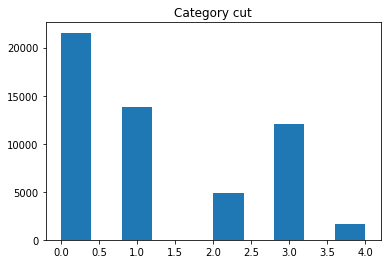

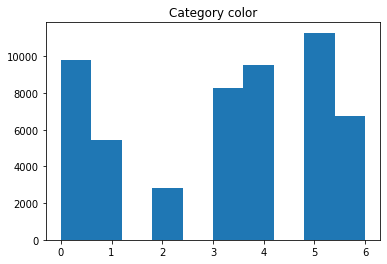

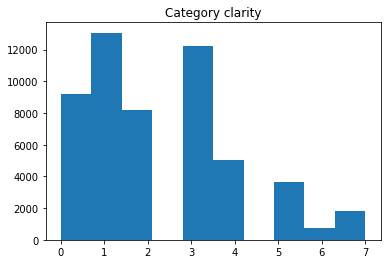

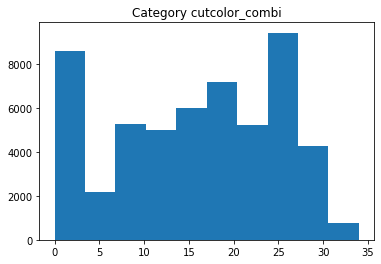

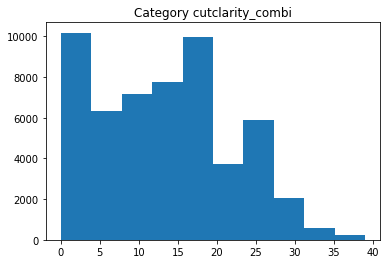

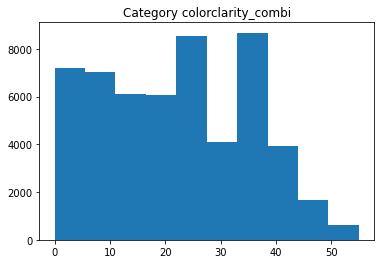

In [6]:
# カテゴリ変数をstrに変換 fillna 対策
df = df.astype({
    cat_col: str for cat_col in categorical_cols
})

# カテゴリ変数の前処理
pipe = xfeat.Pipeline([
    # カテゴリ変数を選択
    xfeat.SelectCategorical(),
    # カテゴリ同士の組み合わせ CFGで設定可能
    xfeat.ConcatCombination(r=CFG.CatPattern),
    # ラベルエンコード
    xfeat.LabelEncoder(output_suffix=''),
])

cat_df = pipe.fit_transform(df)

print(f"Category Cols Create: {len(categorical_cols)} >> {len(cat_df.columns.tolist())}")
categorical_cols = cat_df.columns.tolist()

print(f"Now Category Cols: {categorical_cols}")

for cat in categorical_cols:
  plt.hist(cat_df[cat])
  plt.title(f"Category {cat}") 
  plt.show()

In [7]:
# 元のデータフレームと結合する
df = pd.concat([cat_df, df[numerical_cols + [CFG.TargetCol] ]], axis=1)

In [8]:
# カテゴリ変数を中心にした集約特徴量
for cat_col in categorical_cols:
    df, _ = xfeat.aggregation(df,
                              group_key=cat_col,
                              group_values=numerical_cols,
                              agg_methods=[
                                  'sum',
                                  'min',
                                  'max',
                                  'mean',
                                  'median',
                                  'std'
                              ],
                              )

In [9]:
print(f'add aggregation features: {len(df.columns)}')

add aggregation features: 229


### 量的変数の拡張

In [10]:
if not CFG.TestDataPath:
  # テストデータがない時
  train_df, test_df = train_test_split(df,
                                        test_size=0.35,
                                        shuffle=True,
                                        random_state=42)
  

folds = KFold(n_splits=CFG.KFold,
              shuffle=True,
              random_state=42)

pipe = xfeat.Pipeline([
    # カウントエンコード
    xfeat.CountEncoder(input_cols=categorical_cols),

    # ターゲットエンコード
    xfeat.TargetEncoder(input_cols=categorical_cols,
                        target_col=CFG.TargetCol,
                        fold=folds),
                       
    # 量的変数の組み合わせ特徴量
    xfeat.ArithmeticCombinations(input_cols=numerical_cols,
                                  operator='+',
                                  r=CFG.NumPatter,
                                  output_suffix='_plus'),
                       
    xfeat.ArithmeticCombinations(input_cols=numerical_cols,
                                  operator='*',
                                  r=CFG.NumPatter,
                                  output_suffix='_mul'),
                       
    xfeat.ArithmeticCombinations(input_cols=numerical_cols,
                                  operator='-',
                                  r=CFG.NumPatter,
                                  output_suffix='_minus'),
                       
    xfeat.ArithmeticCombinations(input_cols=numerical_cols,
                                  operator='/',
                                  r=CFG.NumPatter,
                                  output_suffix='_div'),
])

train_df = pipe.fit_transform(train_df)
test_df = pipe.transform(test_df)

print(f'add some features: {len(train_df.columns)}')

add some features: 301


## 学習

In [11]:
def _lgbm_cv(train_x, train_y):
    """LightGBM を使った交差検証のヘルパー関数"""
    lgbm_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
    }
    train_dataset = lgb.Dataset(data=train_x,
                                label=train_y)
    folds = KFold(n_splits=5,
                  shuffle=True,
                  random_state=42)
    cv_result = lgb.cv(lgbm_params,
                       train_dataset,
                       num_boost_round=1_000,
                       folds=folds,
                       return_cvbooster=True,
                       )
    return cv_result


def _rmse(y_true, y_pred):
    """RMSE を計算するヘルパー関数"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse


def _evaluate(train_x, train_y, test_x, test_y):
    """学習用データの CV とテストデータの誤差を確認するヘルパー関数"""
    cv_result = _lgbm_cv(train_x, train_y)

    cv_rmse_mean = cv_result['rmse-mean'][-1]
    print(f'CV RMSE: {cv_rmse_mean}')

    cvbooster = cv_result['cvbooster']
    y_preds = cvbooster.predict(test_x)
    y_pred = np.mean(y_preds, axis=0)
    test_rmse = _rmse(y_pred, test_y)
    print(f'Test RMSE: {test_rmse}')

def objective(df, selector, trial):
    """Optuna の目的関数"""
    # 次に試行する特徴量の組み合わせを得る
    selector.set_trial(trial)
    selector.fit(df)
    input_cols = selector.get_selected_cols()

    # 選択された特徴量から得られる Local CV のスコアを計算する
    train_x = df[input_cols].drop(['price'], axis=1)
    train_y = df['price']
    cv_result = _lgbm_cv(train_x, train_y)
    # スコアの平均を返す
    mean_score = cv_result['rmse-mean'][-1]
    return mean_score

In [16]:
# 選択前のスコアを計算しておく
train_x, train_y = train_df.drop(CFG.TargetCol, axis=1), train_df[CFG.TargetCol]
test_x, test_y = test_df.drop(CFG.TargetCol, axis=1), test_df[CFG.TargetCol]
_evaluate(train_x, train_y, test_x, test_y)

CV RMSE: 544.3920237355757
Test RMSE: 515.0921902775127


In [17]:
# 学習用データセットを使って特徴量選択をする
lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
}
fit_params = {
    'num_boost_round': 1_000,
}
selector = xfeat.GBDTFeatureExplorer(input_cols=train_df.columns.tolist(),
                                      target_col=CFG.TargetCol,
                                      fit_once=True,
                                      threshold_range=(0.1, 1.0),
                                      lgbm_params=lgbm_params,
                                      lgbm_fit_kwargs=fit_params,
                                      )

# メトリックのスコアが良くなる特徴量の組み合わせを探索する
study = optuna.create_study(direction='minimize')
# 最適化する
study.optimize(partial(objective, train_df, selector),
                n_trials=10,
                )

# 探索で見つかった最善の組み合わせを取り出す
selector.from_trial(study.best_trial)
selected_cols = selector.get_selected_cols()

# 特徴量の数をどれだけ減らせたか
print(f'selected features: {len(selected_cols)}')

# 選択後のスコアを計算する
train_x = train_df[selected_cols].drop(CFG.TargetCol, axis=1)
test_x = test_df[selected_cols].drop(CFG.TargetCol, axis=1)
_evaluate(train_x, train_y, test_x, test_y)

[I 2022-07-29 08:23:41,487] A new study created in memory with name: no-name-50ae1566-a3c6-40b5-994e-b8b465bb0f8c
[I 2022-07-29 08:26:31,396] Trial 0 finished with value: 543.4549180356445 and parameters: {'GBDTFeatureSelector.threshold': 0.5940921574533661}. Best is trial 0 with value: 543.4549180356445.
[I 2022-07-29 08:27:08,921] Trial 1 finished with value: 589.085819767142 and parameters: {'GBDTFeatureSelector.threshold': 0.15697669078686557}. Best is trial 0 with value: 543.4549180356445.
[I 2022-07-29 08:27:42,680] Trial 2 finished with value: 913.2215979827158 and parameters: {'GBDTFeatureSelector.threshold': 0.13467816475453698}. Best is trial 0 with value: 543.4549180356445.
[I 2022-07-29 08:28:33,347] Trial 3 finished with value: 582.5741666754269 and parameters: {'GBDTFeatureSelector.threshold': 0.22258397819330417}. Best is trial 0 with value: 543.4549180356445.
[I 2022-07-29 08:29:55,077] Trial 4 finished with value: 540.970663501301 and parameters: {'GBDTFeatureSelector.

selected features: 88
CV RMSE: 544.6283607517265
Test RMSE: 515.3024435362905
